In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'

NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

 
act_directory = 'C:\\\\Users\\insan\\Documents\\Analysis_Cache\\Analysis_Cache'
ops_directory = 'C:\\\\Users\\insan\\Documents\\Opsin_Cache\\Opsin_Cache' # use when on pc
beh_directory = 'C:\\\\Users\\Insan\\Documents\\Behavioor'
#ops_directory = '/Users/mikeymalina/Data/Insanally/Opsin_Cache' # use when on mac


didnotlearnopsinanimals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
dualrecanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108'] # ,'DS_15','DS_19'


animalnames =  ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174', 'BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108']
animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#Dual Recording Animals
animals['BS_67'].reversal = 7
animals['BS_108'].reversal = 7
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
animals['BS_61'].reversal = 9    ###
animals['BS_70'].reversal = 8
animals['BS_72'].reversal = 6
animals['BS_87'].reversal = 6


#Opsin Animals
animals['BS_86'].reversal = 14
#animals['BS_92'].reversal = 9
animals['BS_100'].reversal = 11
#animals['BS_103'].reversal = 8
#animals['BS_111'].reversal = 8
animals['BS_119'].reversal = 10
animals['BS_123'].reversal = 9
animals['BS_128'].reversal = 6
animals['BS_131'].reversal = 14
#animals['BS_139'].reversal = 10
animals['BS_163'].reversal = 13
#animals['BS_165'].reversal = np.Inf
animals['BS_174'].reversal = 14
#animals['BS_179'].reversal = 16
#animals['BS_191'].reversal = 10
#animals['BS_192'].reversal = 7





In [2]:
animals_in_cache = []
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    if sessionfile.meta.animal == 'PB_86':
        animals_in_cache.append('BS_86')
    elif sessionfile.meta.animal == 'PB_92':
        animals_in_cache.append('BS_92')
    else:
        animals_in_cache.append(sessionfile.meta.animal)
        
animals_in_cache = np.unique(animals_in_cache)

training_days_recorded = dict()
for animal in animals_in_cache:
    training_days_recorded[animal] = []
    
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal == 'PB_86':
        training_days_recorded['BS_86'].append(sessionfile.meta.day_of_training)
    elif sessionfile.meta.animal == 'PB_92': 
        training_days_recorded['BS_92'].append(sessionfile.meta.day_of_training)
    else:
        training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
        
## computing # of sessions to work on for opsin animals
EnumSession = []
sessions = os.listdir(ops_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    if sessionfile.meta.animal not in didnotlearnopsinanimals:
        continue
  
    EnumSession.append(session)

100%|██████████| 101/101 [00:01<00:00, 68.72it/s]


BS_86
7
BS_100
3
BS_119
5
BS_123
3
BS_128
3
BS_131
5
BS_163
3
BS_174
2


Text(0.5, 0.075, 'Day of training')

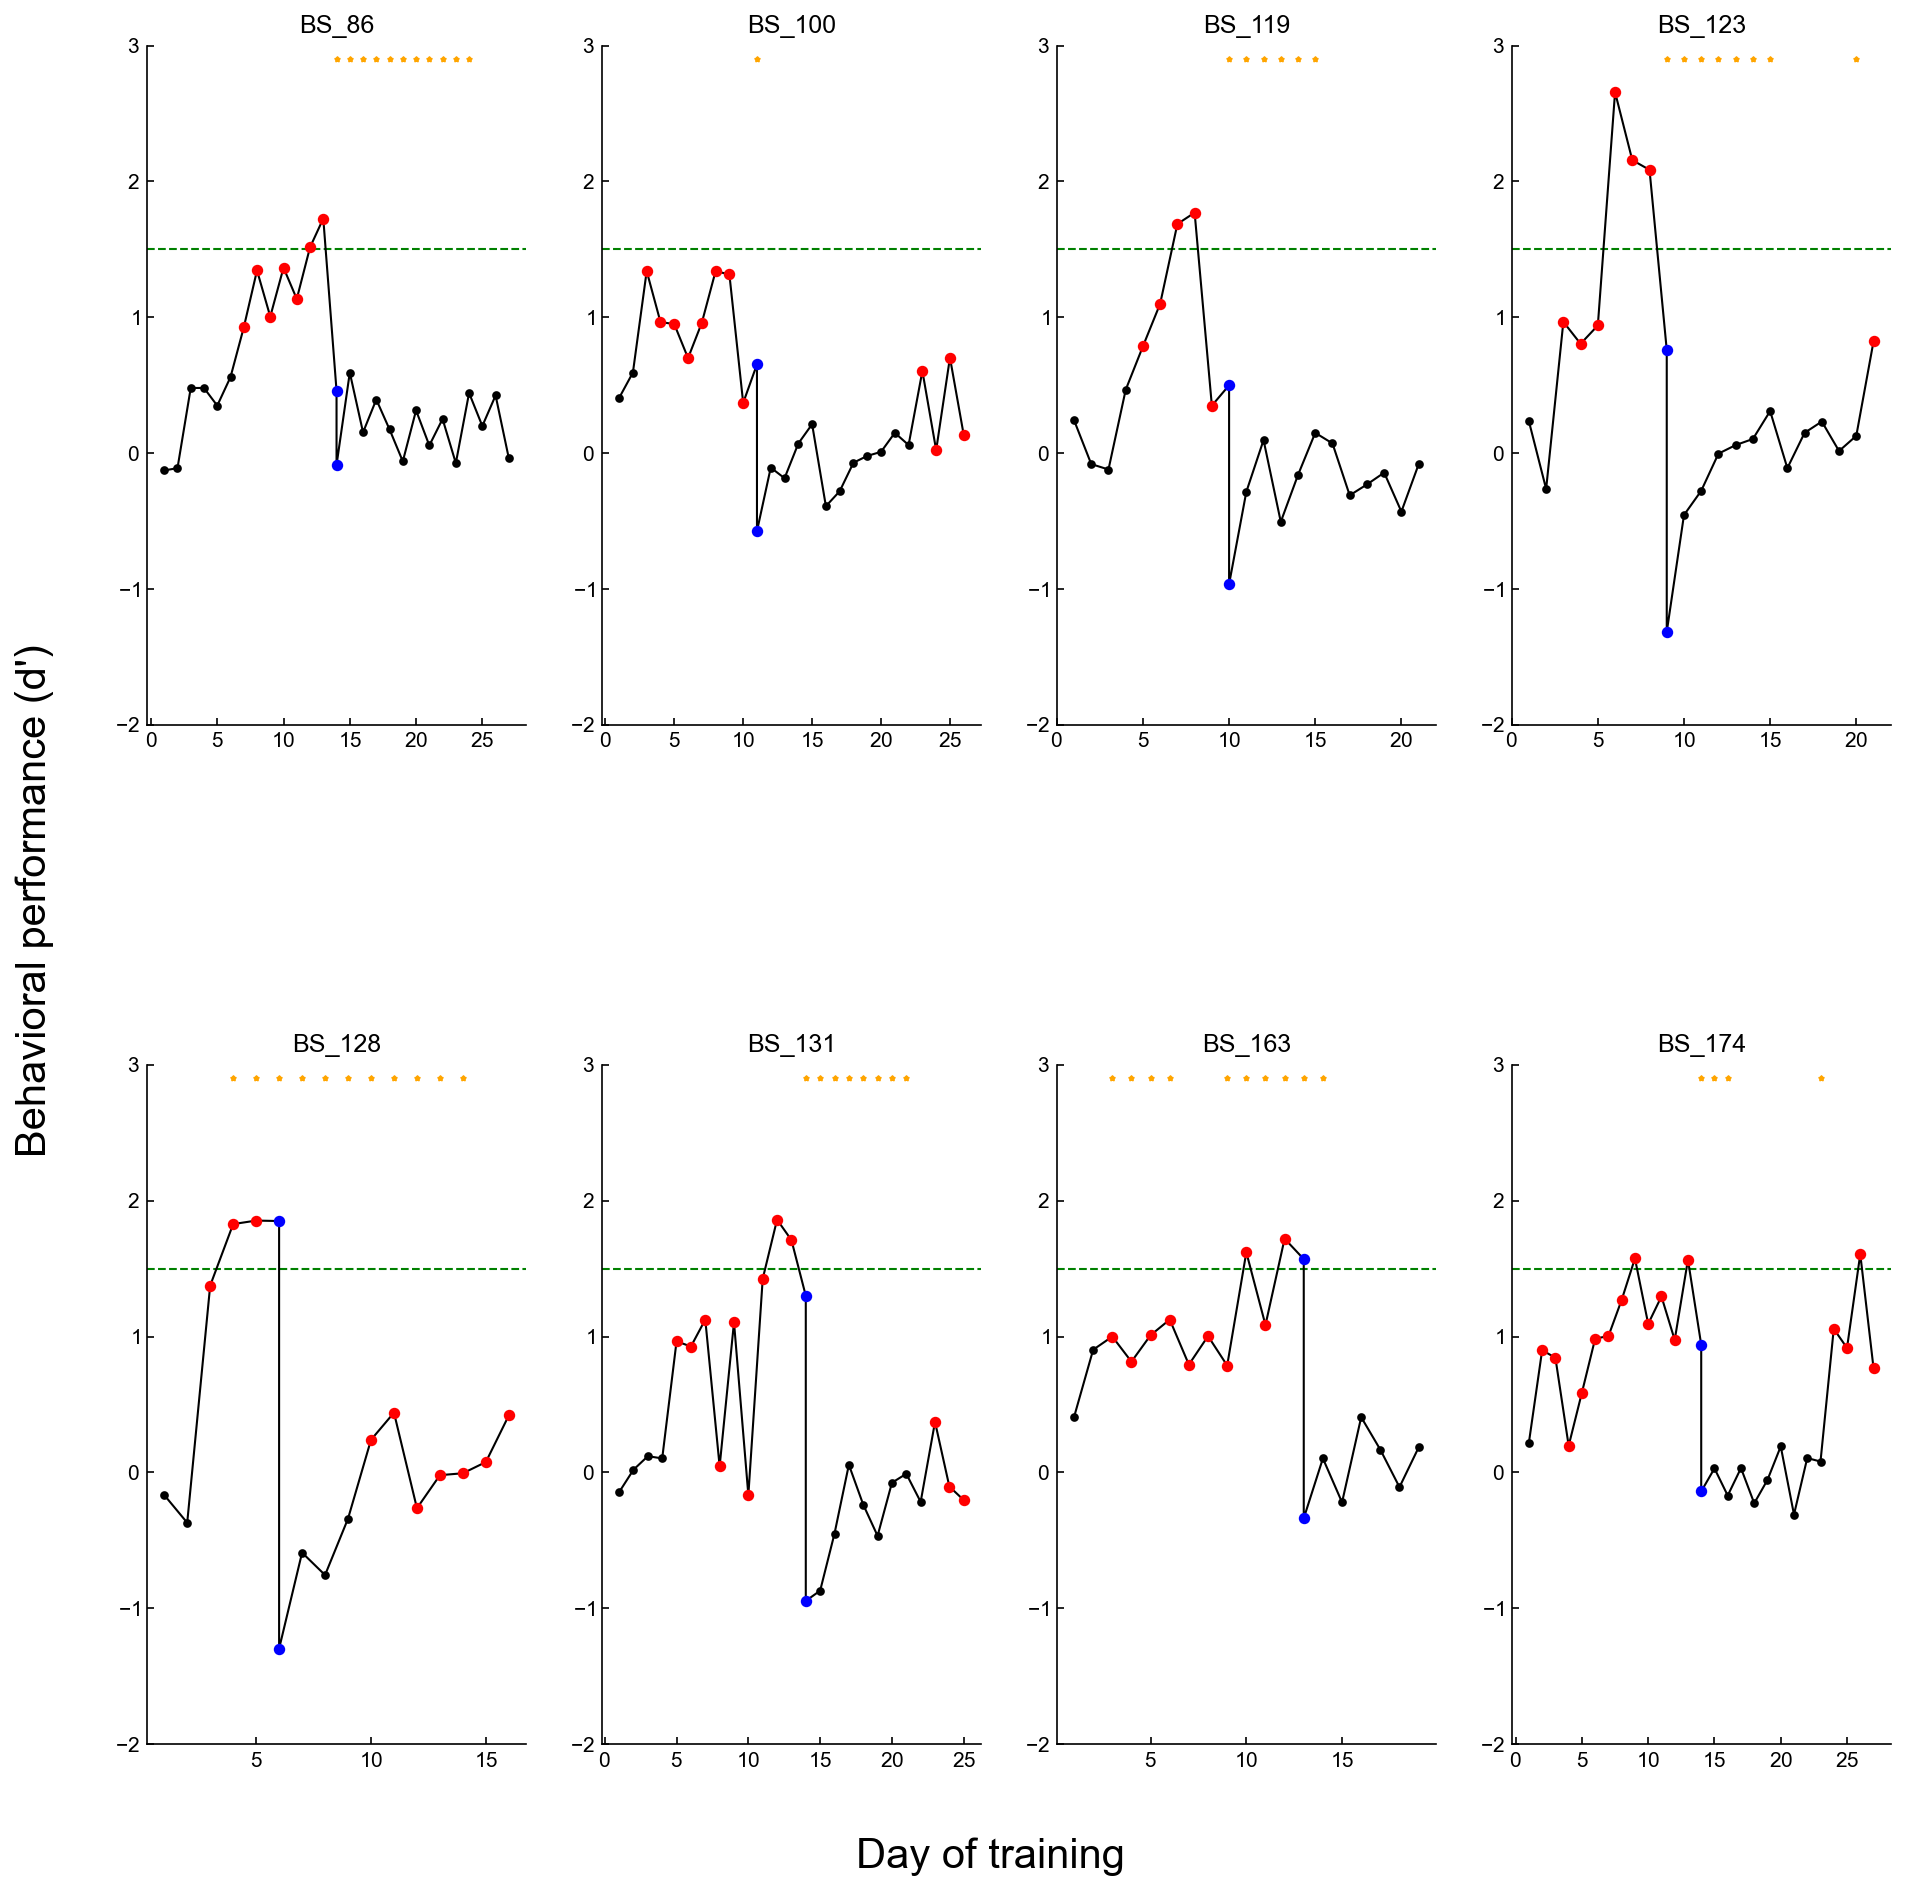

In [3]:
filename = os.path.join('C:\\\\Users\\insan\\Documents\\DataForJMTTotal.csv') # use when in lab
#filename = os.path.join('D:\\\\DataForJMTTotal.csv')
csv = pd.read_csv(filename)

postthresholds = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(15,15))
    gs = fig.add_gridspec(2,4,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(2),range(4))]
    #plt.delaxes(axs[14])
    #plt.delaxes(axs[15])

premiddlecutoffs = dict()
postmiddlecutoffs = dict()
PERphases = dict()

for animalidx,animal in enumerate(didnotlearnopsinanimals):
    print(animal)
    PERphases[animal] = dict()
    
    condname = 'd\' ' + animal
    pc_condname = 'Percent correct ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    cond_pc = csv[pc_condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
            
        if day > animals[animal].reversal+1: #  +1 because the csv stores the switch day as two entries
            #Calculate PERphase
            PC = cond_pc[idx]
            if PC <= 47.5:
                PERphases[animal][day-1] = 'perseveration'
            elif PC >= 52.5:
                PERphases[animal][day-1] = 'refinement'
            else:
                PERphases[animal][day-1] = 'exploration'
            
    #days = days - animals[animal].reversal
    
    prereversaldays = []
    prereversaldps = []
    maxreversaldp = -np.Inf
    minreversaldp = np.Inf
    postreversaldays = []
    postreversaldps = []
    for idx,day in enumerate(days):
        if day < animals[animal].reversal or np.isnan(animals[animal].reversal):
            prereversaldays.append(day)
            prereversaldps.append(cond[idx])
        if day == animals[animal].reversal:
            maxreversaldp = max(cond[idx],maxreversaldp)
            minreversaldp = min(cond[idx],minreversaldp)
        if day > animals[animal].reversal and not np.isnan(cond[idx]):
            postreversaldays.append(day)
            postreversaldps.append(cond[idx])
            
    #Prereversal threshold
    maxperf = np.nanmax(np.concatenate((prereversaldps,[1.5])))
    minperf = np.nanmin(prereversaldps)
    prethreshold = minperf + 0.4*(maxperf-minperf)
    #Postreversal threshold
    try:
        maxperf = np.nanmax(np.concatenate((postreversaldps,[1.5])))
        minperf = np.nanmin(postreversaldps)
    except:
        print(animal+' has no post-reversal')
        maxperf = np.nan
        minperf = np.nan
    postthreshold = minperf + 0.4*(maxperf-minperf)
    
    postthresholds[animal] = postthreshold
    
    prereversaldays = np.array(prereversaldays)
    prereversaldps = np.array(prereversaldps)
    postreversaldays = np.array(postreversaldays)
    postreversaldps = np.array(postreversaldps)
    
    premiddlebool = np.greater_equal(prereversaldps,prethreshold)
    for idx,day in enumerate(prereversaldays):
        if premiddlebool[idx]:
            premiddlebool[idx:(len(premiddlebool)-1)].fill(True)
        #if not premiddlebool[idx]:
        #    premiddlebool[0:idx].fill(False)
    if np.any(premiddlebool):
        premiddlefirstday = np.min(prereversaldays[premiddlebool])
    else:
        premiddlefirstday = np.Inf
        
    print(premiddlefirstday)
                     
    postmiddlebool = np.greater_equal(postreversaldps,postthreshold)
    for idx,day in enumerate(postreversaldays):
        if postmiddlebool[idx]:
            postmiddlebool[idx:(len(postmiddlebool)-1)].fill(True)
        #if not postmiddlebool[idx]:
        #    postmiddlebool[0:idx].fill(False)
    if np.any(postmiddlebool):
        postmiddlefirstday = np.min(postreversaldays[postmiddlebool])
    else:
        postmiddlefirstday = np.Inf
    
    if animal == 'BS_95':
        premiddlefirstday = 4
    if animal == 'BS_49':
        premiddlefirstday = 7
    if animal in ['BS_83','BS_50']:
        postmiddlefirstday = np.Inf
    if animal == 'BS_86':
        postmiddlefirstday = np.Inf
    
    premiddlecutoffs[animal] = premiddlefirstday
    postmiddlecutoffs[animal] = postmiddlefirstday
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        #Pre Middle
        premiddle = np.logical_and( np.greater_equal(days,premiddlefirstday), np.less(days,animals[animal].reversal) )
        ax.scatter(days[premiddle],cond[premiddle],color='r',s=20,zorder=10)
        #Post Middle
        postmiddle = np.greater_equal(days,postmiddlefirstday)
        ax.scatter(days[postmiddle],cond[postmiddle],color='r',s=20,zorder=10)
        #Switch
        switch = np.equal(days,animals[animal].reversal)
        ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)

        ax.set_title(animal)
        
fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

In [4]:
def cluster_across_day_counter():

    # computing how many sessions and clusters all togeht
    dual_day_count = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    dual_numClusters_total = np.zeros((13,14))

    opsin_day_count = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    opsin_numClusters_total = np.zeros((13,8))

    ## COMPUTE SESSIONS AND CLUSTERS FOR DUAL ACROSS DAYS
    #####################################################
    for session in os.listdir(act_directory):

        sessionfile = ilep.loadSessionCached(act_directory,session)    
        animal = sessionfile.meta.animal
        
        ###### animal days to remove for various reasons
        if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
            continue
        if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
            continue
        if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
            continue
        ######

        # only AC clusters
        if not sessionfile.meta.region == 'AC':
            continue

        # only control animals
        if animal not in dualrecanimalnames:
            continue

        day_of_training = sessionfile.meta.day_of_training
        reversal = animals[animal].reversal

        # only want day of reversal and on
        if day_of_training < reversal:
            continue

        # only want max 12 days post-reversal
        if day_of_training > reversal + 12:
            continue

        #rowidx = day_of_training - reversal - 1
        rowidx = day_of_training - reversal 

        # compute how many sessions (across animals) for days 1:12
        dual_day_count[rowidx] = dual_day_count[rowidx] + 1

        # specifying each animal
        if animal == 'BS_40':
            colidx = 0
        if animal == 'BS_41':
            colidx = 1
        if animal == 'BS_42':
            colidx = 2
        if animal == 'BS_49':
            colidx = 3
        if animal == 'BS_50':
            colidx = 4
        if animal == 'BS_51':
            colidx = 5
        if animal == 'BS_56':
            colidx = 6
        if animal == 'BS_59':
            colidx = 7
        if animal == 'BS_61':
            colidx = 8
        if animal == 'BS_67':
            colidx = 9
        if animal == 'BS_70':
            colidx = 10
        if animal == 'BS_72':
            colidx = 11
        if animal == 'BS_87':
            colidx = 12
        if animal == 'BS_108':
            colidx = 13       

        # compute total # of clusters for given animal for given session
        numClusters = np.shape(sessionfile.clusters.good)[0]

        # place that # of clusters in session,animal index in row
        dual_numClusters_total[rowidx][colidx] = dual_numClusters_total[rowidx][colidx] + numClusters   
        dual_numClusters_across_days = np.sum(dual_numClusters_total, axis = 1)


    ## COMPUTE SESSIONS AND CLUSTERS FOR OPSIN ACROSS DAYS
    #####################################################
    for session in os.listdir(ops_directory):

        sessionfile = ilep.loadSessionCached(ops_directory,session)    
        animal = sessionfile.meta.animal
        
               
        ###### remove days that are cloudy
        if sessionfile.meta.cloudy == True:
            continue

        # only AC clusters
        if not sessionfile.meta.region == 'AC':
            continue

        # only control animals
        if animal not in didnotlearnopsinanimals:
            continue

        day_of_training = sessionfile.meta.day_of_training
        reversal = animals[animal].reversal

        # only want days post-reversal
        if day_of_training < reversal:
            continue

        # only want max 12 days post-reversal
        if day_of_training > reversal + 12:
            continue

        rowidx = day_of_training - reversal 

        # compute how many sessions (across animals) for days 1:12
        opsin_day_count[rowidx] = opsin_day_count[rowidx] + 1


        # specifying each animal
        if animal == 'BS_86':
            colidx = 0
        if animal == 'BS_100':
            colidx = 1
        if animal == 'BS_119':
            colidx = 2
        if animal == 'BS_123':
            colidx = 3
        if animal == 'BS_128':
            colidx = 4
        if animal == 'BS_131':
            colidx = 5
        if animal == 'BS_163':
            colidx = 6
        if animal == 'BS_174':
            colidx = 7

        # compute total # of clusters for given animal for given session
        numClusters = np.shape(sessionfile.clusters.good)[0]

        # place that # of clusters in session,animal index in row
        opsin_numClusters_total[rowidx][colidx] = opsin_numClusters_total[rowidx][colidx] + numClusters   
        opsin_numClusters_across_days = np.sum(opsin_numClusters_total, axis = 1)
    
    print("Opsin clusters across 12 days post_reversal:", (opsin_numClusters_across_days))
    print("Dual clusters across 12 days post_reversal:", (dual_numClusters_across_days))
    
    return opsin_numClusters_across_days, dual_numClusters_across_days

In [5]:
# will tell you how many clusters there are for each group across days, use this to check cell below values are correct
opsin_numClusters_across_days, dual_numClusters_across_days = cluster_across_day_counter()


Opsin clusters across 12 days post_reversal: [168. 136. 150.  53.  87.  52.  27.  17.   0.  48.   0.  16.   0.]
Dual clusters across 12 days post_reversal: [130. 120.  90. 128.  48.  78.  76.  45.  59.  25.  22.  34.   4.]


In [185]:
sessionfile.meta.cloudy

True

In [190]:
if sessionfile.meta.cloudy == True:
    print('yuh')

yuh


In [182]:
###############################################################
# GRABBING CLUSTER FR MODS FOR EACH DAY, BEHAVIORAL OUTCOMES 
###############################################################

# including preceding three parts of days, day before reversal, 
# day of reversal pre-reversal, day of reversal post-reversal

# DUALREC ANIMALS
##############################################################
dual_day_clust_off_hit = [0,0,0,0,0,0,0,0,0,0,0,0,0] # size 13 for the 13 sessions we are including
dual_day_clust_off_miss = [0,0,0,0,0,0,0,0,0,0,0,0,0]
dual_day_clust_off_creject = [0,0,0,0,0,0,0,0,0,0,0,0,0]
dual_day_clust_off_falarm = [0,0,0,0,0,0,0,0,0,0,0,0,0]
dual_day_clust_off_corr = [0,0,0,0,0,0,0,0,0,0,0,0,0]


for session in os.listdir(act_directory):
    
    sessionfile = ilep.loadSessionCached(act_directory,session)    
    animal = sessionfile.meta.animal        
           
    ###### animal days to remove for various reasons
    if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
        continue
    if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
        continue
    if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
        continue
    if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
        continue
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
        continue
    ######
    
    # only control animals
    if animal not in dualrecanimalnames:
        continue
        
    # only AC clusters
    if not sessionfile.meta.region == 'AC':
        continue
                            
    # define session and reversal
    day_of_training = sessionfile.meta.day_of_training
    reversal = animals[animal].reversal  
    day_before_reversal = reversal - 1
    days_since_reversal = day_of_training - reversal
    
    # grabbing pre and post switch values
    if day_of_training == reversal:
        
        # BS_49 has no reversal recordings
        if animal == 'BS_49':
            continue
            
        for idx,cluster in enumerate(sessionfile.clusters.good):
            
            dual_day_clust_off_corr[0] = np.append(dual_day_clust_off_corr[0], sessionfile.responsiveness[cluster]['post_switch_correct'].FRmodulation)
            dual_day_clust_off_hit[0] = np.append(dual_day_clust_off_hit[0], sessionfile.responsiveness[cluster]['post_switch_hit'].FRmodulation)
            dual_day_clust_off_miss[0] = np.append(dual_day_clust_off_miss[0], sessionfile.responsiveness[cluster]['post_switch_miss'].FRmodulation)
            dual_day_clust_off_creject[0] = np.append(dual_day_clust_off_creject[0], sessionfile.responsiveness[cluster]['post_switch_creject'].FRmodulation)
            dual_day_clust_off_falarm[0] = np.append(dual_day_clust_off_falarm[0], sessionfile.responsiveness[cluster]['post_switch_falarm'].FRmodulation)
            
    # grabbing days 1-12 post-reversal
    if 0 < days_since_reversal < 13:
        for idx,cluster in enumerate(sessionfile.clusters.good):
            dual_day_clust_off_corr[days_since_reversal] = np.append(dual_day_clust_off_corr[days_since_reversal], sessionfile.responsiveness[cluster]['correct'].FRmodulation)
            dual_day_clust_off_hit[days_since_reversal] = np.append(dual_day_clust_off_hit[days_since_reversal], sessionfile.responsiveness[cluster]['hit'].FRmodulation)
            dual_day_clust_off_miss[days_since_reversal] = np.append(dual_day_clust_off_miss[days_since_reversal], sessionfile.responsiveness[cluster]['miss'].FRmodulation)
            dual_day_clust_off_creject[days_since_reversal] = np.append(dual_day_clust_off_creject[days_since_reversal], sessionfile.responsiveness[cluster]['creject'].FRmodulation)
            dual_day_clust_off_falarm[days_since_reversal] = np.append(dual_day_clust_off_falarm[days_since_reversal], sessionfile.responsiveness[cluster]['falarm'].FRmodulation)
         
    
# removing the zeros I initialized at the top of the script   
dual_off_shape = np.zeros((5,13))
for i in range(13):
    dual_day_clust_off_corr[i] = [ele for ele in dual_day_clust_off_corr[i] if ele != 0]; dual_day_clust_off_corr[i] = [x for x in dual_day_clust_off_corr[i] if str(x) != 'nan']
    dual_day_clust_off_hit[i] = [ele for ele in dual_day_clust_off_hit[i] if ele != 0]; dual_day_clust_off_hit[i] = [x for x in dual_day_clust_off_hit[i] if str(x) != 'nan']
    dual_day_clust_off_miss[i] = [ele for ele in dual_day_clust_off_miss[i] if ele != 0]; dual_day_clust_off_miss[i] = [x for x in dual_day_clust_off_miss[i] if str(x) != 'nan']
    dual_day_clust_off_creject[i] = [ele for ele in dual_day_clust_off_creject[i] if ele != 0]; dual_day_clust_off_creject[i] = [x for x in dual_day_clust_off_creject[i] if str(x) != 'nan']
    dual_day_clust_off_falarm[i] = [ele for ele in dual_day_clust_off_falarm[i] if ele != 0]; dual_day_clust_off_falarm[i] = [x for x in dual_day_clust_off_falarm[i] if str(x) != 'nan']

    dual_off_shape[0,i] = np.shape(dual_day_clust_off_corr[i])[0]
    dual_off_shape[1,i] = np.shape(dual_day_clust_off_hit[i])[0]
    dual_off_shape[2,i] = np.shape(dual_day_clust_off_miss[i])[0]
    dual_off_shape[3,i] = np.shape(dual_day_clust_off_creject[i])[0]
    dual_off_shape[4,i] = np.shape(dual_day_clust_off_falarm[i])[0]
       
        
# OPSIN ANIMALS
##############################################################
opsin_day_clust_on_hit = [0,0,0,0,0,0,0,0,0,0,0,0,0] # size 13 for twelve reversal days plus day of reversal post 
opsin_day_clust_on_miss = [0,0,0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_on_creject = [0,0,0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_on_falarm = [0,0,0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_on_corr = [0,0,0,0,0,0,0,0,0,0,0,0,0]

for session in os.listdir(ops_directory):
     
    sessionfile = ilep.loadSessionCached(ops_directory,session)    
    animal = sessionfile.meta.animal
    
    ##### remove days that are cloudy
    if sessionfile.meta.cloudy == True:
        continue
    
    # only AC clusters
    if not sessionfile.meta.region == 'AC':
        continue
        
    # only opsin animals
    if animal not in didnotlearnopsinanimals:
        continue
       
    # define session and reversal
    day_of_training = sessionfile.meta.day_of_training
    reversal = animals[animal].reversal  
    day_before_reversal = reversal - 1
    days_since_reversal = day_of_training - reversal

    # grabbing pre and post switch values, opsin off
    # grabbing post values, opsin on
    if day_of_training == reversal:
        
        for idx,cluster in enumerate(sessionfile.clusters.good):      
            opsin_day_clust_on_corr[0] = np.append(opsin_day_clust_on_corr[0], sessionfile.responsiveness[cluster]['post_switch_laser_on_correct'].FRmodulation)
            opsin_day_clust_on_hit[0] = np.append(opsin_day_clust_on_hit[0], sessionfile.responsiveness[cluster]['post_switch_laser_on_hit'].FRmodulation)
            opsin_day_clust_on_miss[0] = np.append(opsin_day_clust_on_miss[0], sessionfile.responsiveness[cluster]['post_switch_laser_on_miss'].FRmodulation)
            opsin_day_clust_on_creject[0] = np.append(opsin_day_clust_on_creject[0], sessionfile.responsiveness[cluster]['post_switch_laser_on_creject'].FRmodulation)
            opsin_day_clust_on_falarm[0] = np.append(opsin_day_clust_on_falarm[0], sessionfile.responsiveness[cluster]['post_switch_laser_on_falarm'].FRmodulation)
    
    # grabbing days 1-12 post-reversal
    if 0 < days_since_reversal < 13:
        
        # FOR 4/25, START WORKING FROM HERE 
        for idx,cluster in enumerate(sessionfile.clusters.good):
            opsin_day_clust_on_corr[days_since_reversal] = np.append(opsin_day_clust_on_corr[days_since_reversal], sessionfile.responsiveness[cluster]['laser_on_correct'].FRmodulation)
            opsin_day_clust_on_hit[days_since_reversal] = np.append(opsin_day_clust_on_hit[days_since_reversal], sessionfile.responsiveness[cluster]['laser_on_hit'].FRmodulation)
            opsin_day_clust_on_miss[days_since_reversal] = np.append(opsin_day_clust_on_miss[days_since_reversal], sessionfile.responsiveness[cluster]['laser_on_miss'].FRmodulation)
            opsin_day_clust_on_creject[days_since_reversal] = np.append(opsin_day_clust_on_creject[days_since_reversal], sessionfile.responsiveness[cluster]['laser_on_creject'].FRmodulation)
            opsin_day_clust_on_falarm[days_since_reversal] = np.append(opsin_day_clust_on_falarm[days_since_reversal], sessionfile.responsiveness[cluster]['laser_on_falarm'].FRmodulation)
 
# removing the zeros I initialized at the top of the script, any nans   
# create arrays of # of clusters
opsin_on_shape = np.zeros((5,13))

for i in range(13):
    
    # skipping blank arrays
    if np.shape(opsin_day_clust_on_hit[i]) == ():
        opsin_day_clust_on_hit[i] = []
    if np.shape(opsin_day_clust_on_miss[i]) == ():
         opsin_day_clust_on_miss[i] = []
    if np.shape(opsin_day_clust_on_creject[i]) == ():
         opsin_day_clust_on_creject[i] = []
    if np.shape(opsin_day_clust_on_falarm[i]) == ():
         opsin_day_clust_on_falarm[i] = []
    if np.shape(opsin_day_clust_on_corr[i]) == ():
         opsin_day_clust_on_corr[i] = []
    
    opsin_day_clust_on_hit[i] = [ele for ele in opsin_day_clust_on_hit[i] if ele != 0]; opsin_day_clust_on_hit[i] = [x for x in opsin_day_clust_on_hit[i] if str(x) != 'nan']
    opsin_day_clust_on_miss[i] = [ele for ele in opsin_day_clust_on_miss[i] if ele != 0]; opsin_day_clust_on_miss[i] = [x for x in opsin_day_clust_on_miss[i] if str(x) != 'nan']
    opsin_day_clust_on_creject[i] = [ele for ele in opsin_day_clust_on_creject[i] if ele != 0]; opsin_day_clust_on_creject[i] = [x for x in opsin_day_clust_on_creject[i] if str(x) != 'nan']
    opsin_day_clust_on_falarm[i] = [ele for ele in opsin_day_clust_on_falarm[i] if ele != 0]; opsin_day_clust_on_falarm[i] = [x for x in opsin_day_clust_on_falarm[i] if str(x) != 'nan']
    opsin_day_clust_on_corr[i] = [ele for ele in opsin_day_clust_on_corr[i] if ele != 0]; opsin_day_clust_on_corr[i] = [x for x in opsin_day_clust_on_corr[i] if str(x) != 'nan']

    opsin_on_shape[0,i] = np.shape(opsin_day_clust_on_corr[i])[0]
    opsin_on_shape[1,i] = np.shape(opsin_day_clust_on_hit[i])[0]
    opsin_on_shape[2,i] = np.shape(opsin_day_clust_on_miss[i])[0]
    opsin_on_shape[3,i] = np.shape(opsin_day_clust_on_creject[i])[0]
    opsin_on_shape[4,i] = np.shape(opsin_day_clust_on_falarm[i])[0]

## Plot laser ON vs Control FR modulation across days post-reversal

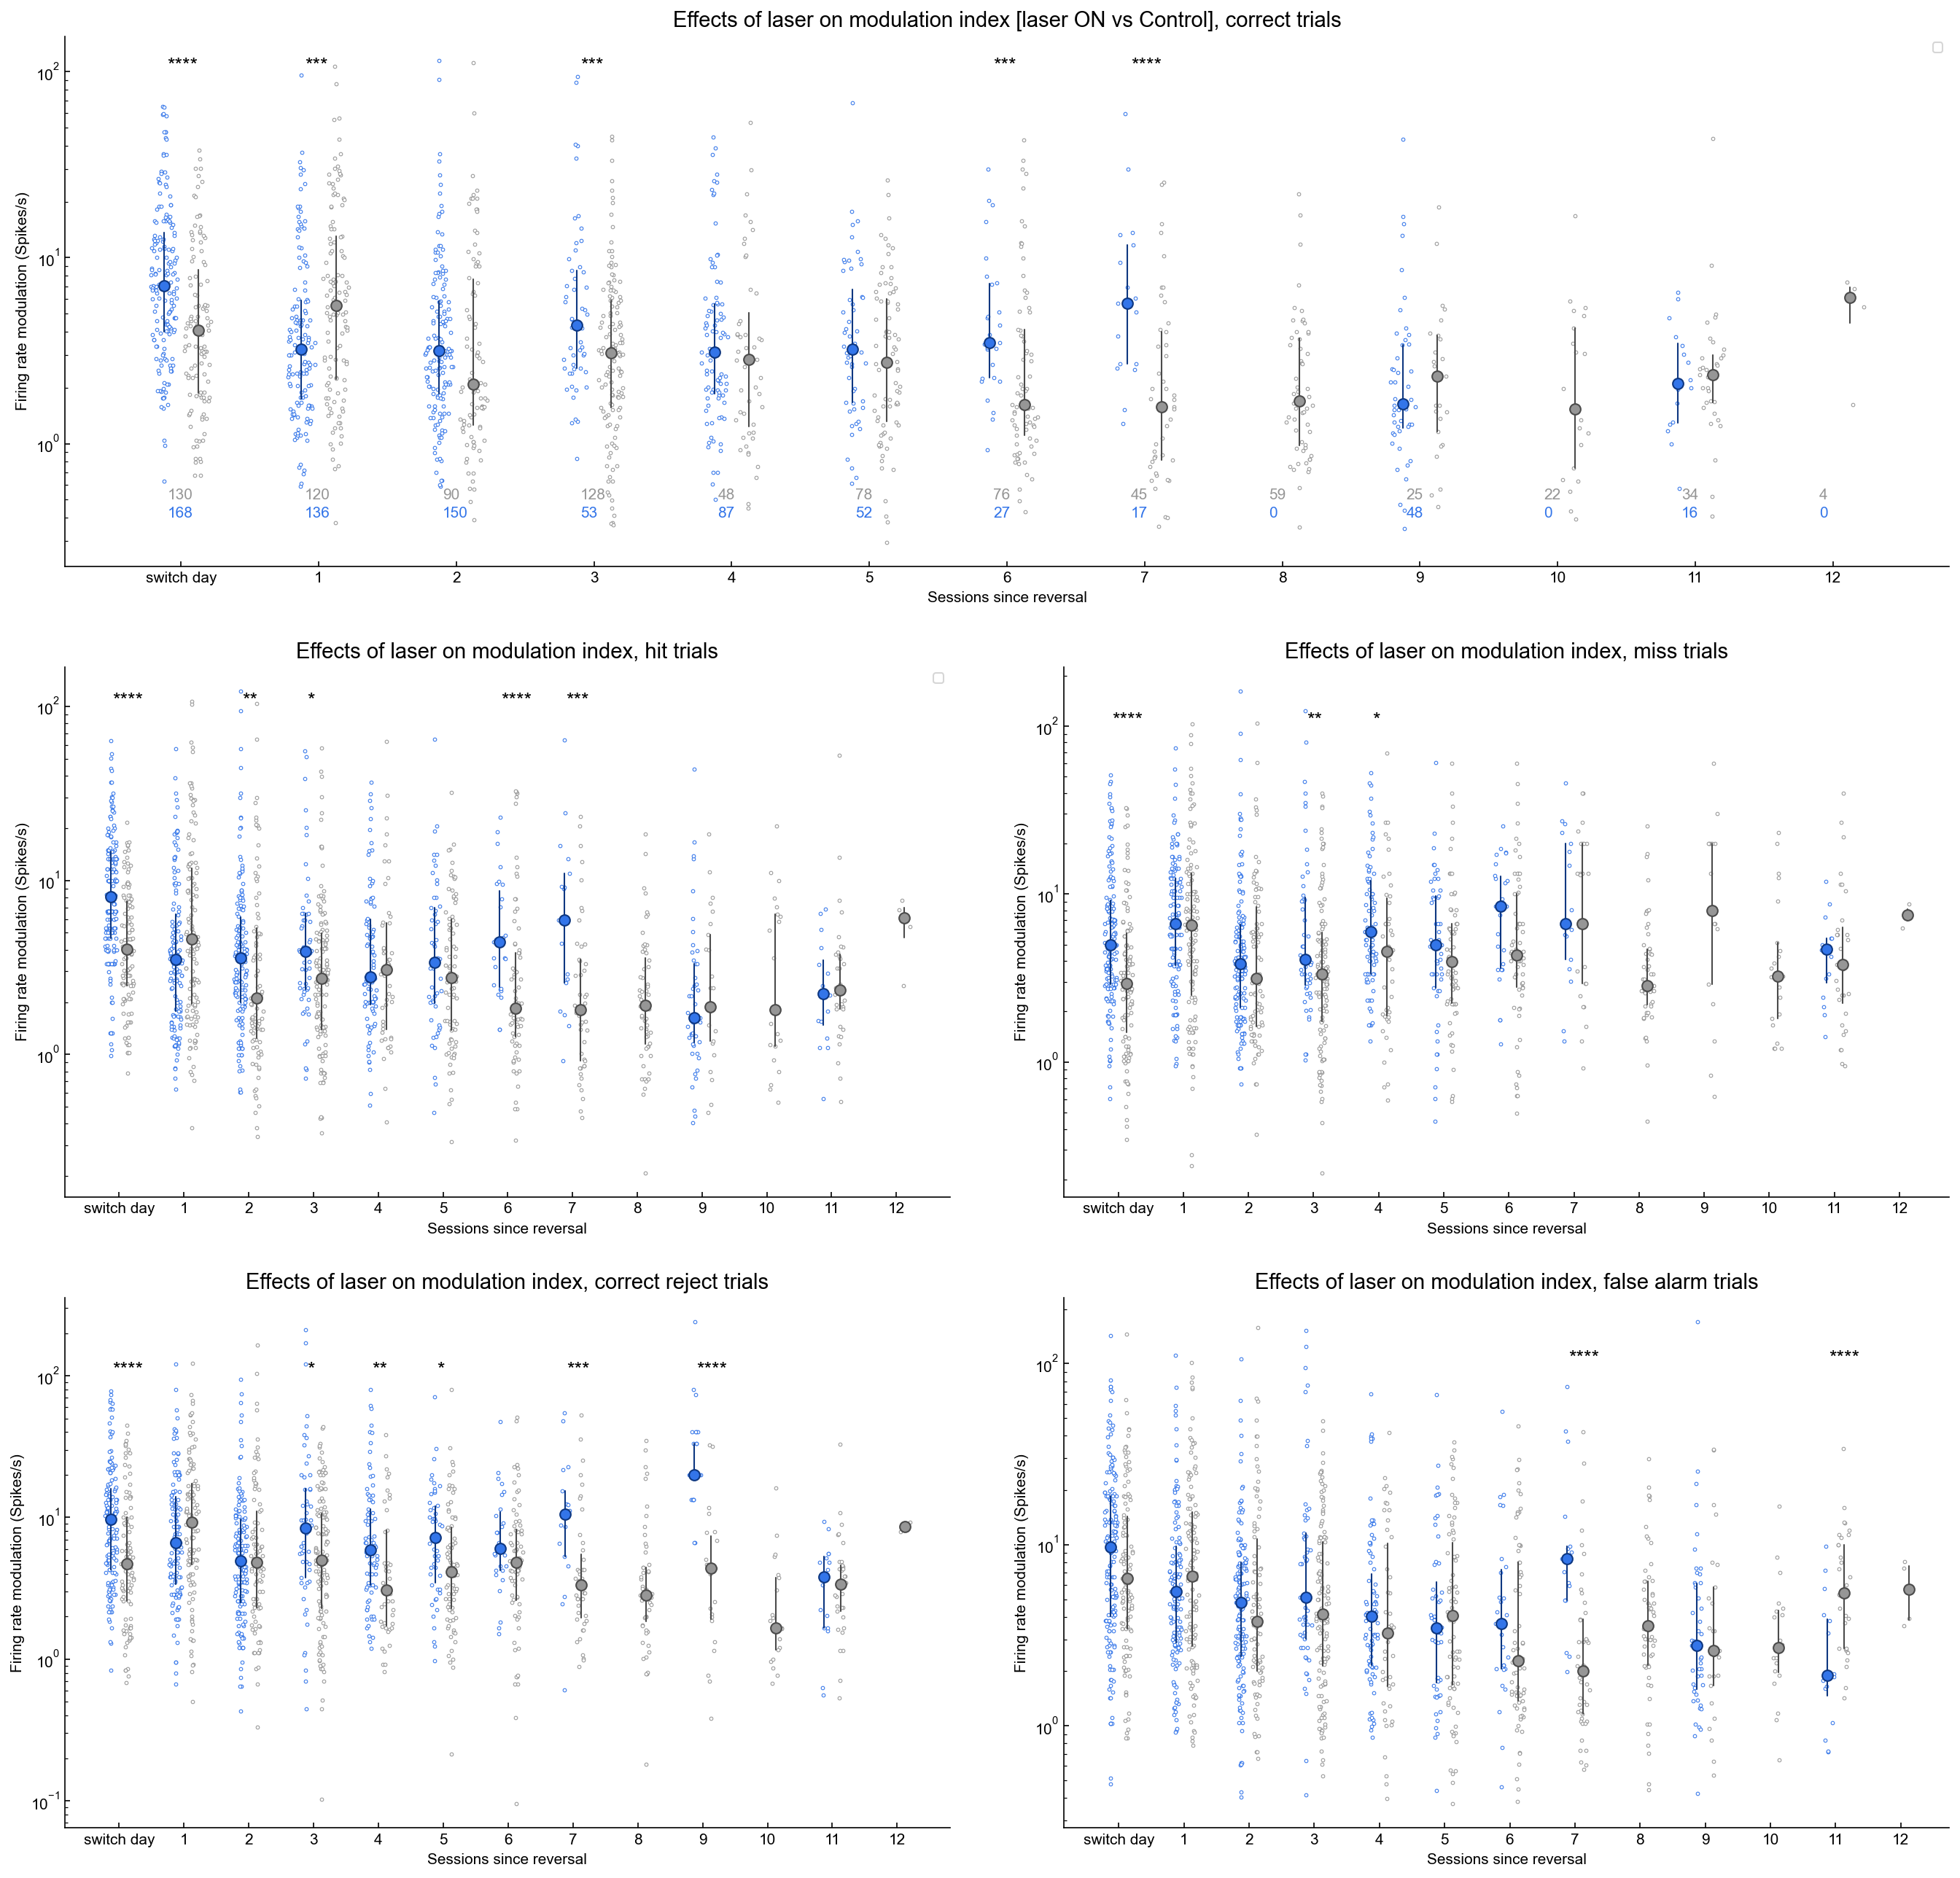

In [189]:
import numpy as np
import matplotlib.pyplot as plt

# fs = 18  # fontsize
# fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(16, 12))
# fig.tight_layout(pad=5)

fig,axs = plt.subplots(6,1)
fig.set_figheight(18)
fig.set_figwidth(28)

axs[0] = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
axs[1] = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1)
axs[2] = plt.subplot2grid(shape=(3, 3), loc=(1, 1), rowspan=1)
axs[3] = plt.subplot2grid((3, 3), (2, 0))
axs[4] = plt.subplot2grid((3, 3), (2, 1), colspan=1)
fig.tight_layout(pad=5)

fs=14

################################################################################################
## CORRECT
################################################################################################
sig = [0 for element in range(13)]
pval =[0 for element in range(13)]
for i in range(13):
    
    opsin_test = opsin_day_clust_on_corr
    dual_test = dual_day_clust_off_corr
    
    # skipping tests for days with no data
    if opsin_test[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
        
    test = mannwhitneyu(opsin_test[i][:],dual_test[i][:])
    if opsin_test[i] != []:
        pval[i] = test.pvalue
        sig[i] = np.abs(pval[i]) < 0.05

#################### JACKS PLOTTING CODE ########################
data_ON = np.concatenate(opsin_day_clust_on_corr)
X_ON = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(opsin_day_clust_on_corr)])+1
_,Y_ON = ilep.violin(X_ON,data_ON)
X_ON,_ = ilep.violin(X_ON,np.log10(data_ON),width=0.25)
X_ON -= 0.125

data_OFF = np.concatenate(dual_day_clust_off_corr)
X_OFF = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(dual_day_clust_off_corr)])+1
_,Y_OFF = ilep.violin(X_OFF,data_OFF)
X_OFF,_ = ilep.violin(X_OFF,np.log10(data_OFF),width=0.25)
X_OFF += 0.125

size = 5
axs[0].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
axs[0].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, laser ON
median_ON = np.copy(opsin_day_clust_on_corr)
for i in range(13):  
    median_ON[i] = np.median(opsin_day_clust_on_corr[i])       
for idx,column in enumerate(opsin_day_clust_on_corr):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[0].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    axs[0].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, laser OFF
median_ON = np.copy(dual_day_clust_off_corr)
for i in range(13):  
    median_ON[i] = np.median(dual_day_clust_off_corr[i])       
for idx,column in enumerate(dual_day_clust_off_corr):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(GOOD_GREY)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[0].scatter([idx+1+0.125], [median], ec=border_color,fc=GOOD_GREY, s=summary_size,lw=summary_width, zorder=10)
    axs[0].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
##############################################################
# cleaning up axes
axs[0].set_yscale('log')
axs[0].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
axs[0].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
axs[0].set_ylabel('Firing rate modulation (Spikes/s)')
axs[0].set_xlabel('Sessions since reversal')
axs[0].set_title('Effects of laser on modulation index [laser ON vs Control], correct trials', fontsize=fs)
axs[0].legend('Laser on', 'Control')
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(13):

    if 0.01 < pval[i] < 0.05:
        axs[0].text(i+0.9,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        axs[0].text(i+0.9,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        axs[0].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        axs[0].text(i+0.9,sigYs, str('****'), size = 13)

# plotting # of clusters
for i in range(13):
    axs[0].text(days[i]-.1,0.4, int(opsin_numClusters_across_days[i]), color = LASER_COLOR)
    axs[0].text(days[i]-.1,0.5, int(dual_numClusters_across_days[i]), color = GOOD_GREY)
    
################################################################################################
## HIT
################################################################################################
sig = [0 for element in range(13)]
pval =[0 for element in range(13)]
for i in range(13):
    
    opsin_test = opsin_day_clust_on_hit
    dual_test = dual_day_clust_off_hit
    
    # skipping tests for days with no data
    if opsin_test[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
        
    test = mannwhitneyu(opsin_test[i][:],dual_test[i][:])
    if opsin_test[i] != []:
        pval[i] = test.pvalue
        sig[i] = np.abs(pval[i]) < 0.05

#################### JACKS PLOTTING CODE ########################
data_ON = np.concatenate(opsin_day_clust_on_hit)
X_ON = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(opsin_day_clust_on_hit)])+1
_,Y_ON = ilep.violin(X_ON,data_ON)
X_ON,_ = ilep.violin(X_ON,np.log10(data_ON),width=0.25)
X_ON -= 0.125

data_OFF = np.concatenate(dual_day_clust_off_hit)
X_OFF = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(dual_day_clust_off_hit)])+1
_,Y_OFF = ilep.violin(X_OFF,data_OFF)
X_OFF,_ = ilep.violin(X_OFF,np.log10(data_OFF),width=0.25)
X_OFF += 0.125

size = 5
axs[1].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
axs[1].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, laser ON
median_ON = np.copy(opsin_day_clust_on_hit)
for i in range(13):  
    median_ON[i] = np.median(opsin_day_clust_on_hit[i])       
for idx,column in enumerate(opsin_day_clust_on_hit):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[1].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    axs[1].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, laser OFF
median_ON = np.copy(dual_day_clust_off_hit)
for i in range(13):  
    median_ON[i] = np.median(dual_day_clust_off_hit[i])       
for idx,column in enumerate(dual_day_clust_off_hit):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(GOOD_GREY)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[1].scatter([idx+1+0.125], [median], ec=border_color,fc=GOOD_GREY, s=summary_size,lw=summary_width, zorder=10)
    axs[1].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
##############################################################
# cleaning up axes
axs[1].set_yscale('log')
axs[1].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
axs[1].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
axs[1].set_ylabel('Firing rate modulation (Spikes/s)')
axs[1].set_xlabel('Sessions since reversal')
axs[1].set_title('Effects of laser on modulation index, hit trials', fontsize=fs)
axs[1].legend('Laser on', 'Control')
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(13):

    if 0.01 < pval[i] < 0.05:
        axs[1].text(i+0.9,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        axs[1].text(i+0.9,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        axs[1].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        axs[1].text(i+0.9,sigYs, str('****'), size = 13)
        
################################################################################################
## MISS
################################################################################################
# compute significance
sig = [0 for element in range(13)]
pval =[0 for element in range(13)]
for i in range(13):
    
    opsin_test = opsin_day_clust_on_miss
    dual_test = dual_day_clust_off_miss
    
    # skipping tests for days with no data
    if opsin_test[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
        
    test = mannwhitneyu(opsin_test[i][:],dual_test[i][:])
    if opsin_test[i] != []:
        pval[i] = test.pvalue
        sig[i] = np.abs(pval[i]) < 0.05
    
#################### JACKS PLOTTING CODE ########################
data_ON = np.concatenate(opsin_day_clust_on_miss)
X_ON = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(opsin_day_clust_on_miss)])+1
_,Y_ON = ilep.violin(X_ON,data_ON)
X_ON,_ = ilep.violin(X_ON,np.log10(data_ON),width=0.25)
X_ON -= 0.125

data_OFF = np.concatenate(dual_day_clust_off_miss)
X_OFF = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(dual_day_clust_off_miss)])+1
_,Y_OFF = ilep.violin(X_OFF,data_OFF)
X_OFF,_ = ilep.violin(X_OFF,np.log10(data_OFF),width=0.25)
X_OFF += 0.125

size = 5
axs[2].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
axs[2].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, LASER ON
median_ON = np.copy(opsin_day_clust_on_miss)
for i in range(13):  
    median_ON[i] = np.median(opsin_day_clust_on_miss[i]) # define median
for idx,column in enumerate(opsin_day_clust_on_miss):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[2].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10) #plot 
    axs[2].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, LASER OFF
median_ON = np.copy(dual_day_clust_off_miss)
for i in range(13):  
    median_ON[i] = np.median(dual_day_clust_off_miss[i])       
for idx,column in enumerate(dual_day_clust_off_miss):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=GOOD_GREY 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[2].scatter([idx+1+0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    axs[2].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
################################################################
# cleaning up axes
axs[2].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
axs[2].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
axs[2].set_ylabel('Firing rate modulation (Spikes/s)')
axs[2].set_xlabel('Sessions since reversal')
axs[2].set_title('Effects of laser on modulation index, miss trials', fontsize=fs)
axs[2].set_yscale('log')

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(13):

    if 0.01 < pval[i] < 0.05:
        axs[2].text(i+0.9,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        axs[2].text(i+0.9,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        axs[2].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        axs[2].text(i+0.9,sigYs, str('****'), size = 13)


################################################################################################
## CORRECT REJECT
################################################################################################
# # compute significance
sig = [0 for element in range(13)]
pval =[0 for element in range(13)]
for i in range(13):
    
    opsin_test = opsin_day_clust_on_creject
    dual_test = dual_day_clust_off_creject
    
    # skipping tests for days with no data
    if opsin_test[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
        
    test = mannwhitneyu(opsin_test[i][:],dual_test[i][:])
    if opsin_test[i] != []:
        pval[i] = test.pvalue
        sig[i] = np.abs(pval[i]) < 0.05
    
#################### JACKS PLOTTING CODE ########################
data_ON = np.concatenate(opsin_day_clust_on_creject)
X_ON = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(opsin_day_clust_on_creject)])+1
_,Y_ON = ilep.violin(X_ON,data_ON)
X_ON,_ = ilep.violin(X_ON,np.log10(data_ON),width=0.25)
X_ON -= 0.125

data_OFF = np.concatenate(dual_day_clust_off_creject)
X_OFF = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(dual_day_clust_off_creject)])+1
_,Y_OFF = ilep.violin(X_OFF,data_OFF)
X_OFF,_ = ilep.violin(X_OFF,np.log10(data_OFF),width=0.25)
X_OFF += 0.125

size = 5
axs[3].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
axs[3].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, LASER ON
median_ON = np.copy(opsin_day_clust_on_creject)
for i in range(13):  
    median_ON[i] = np.median(opsin_day_clust_on_creject[i]) # define median
for idx,column in enumerate(opsin_day_clust_on_creject):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[3].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10) #plot 
    axs[3].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, LASER OFF
median_ON = np.copy(dual_day_clust_off_creject)
for i in range(13):  
    median_ON[i] = np.median(dual_day_clust_off_creject[i])       
for idx,column in enumerate(dual_day_clust_off_creject):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=GOOD_GREY 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[3].scatter([idx+1+0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    axs[3].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
################################################################
# cleaning up axes
axs[3].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
axs[3].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
axs[3].set_ylabel('Firing rate modulation (Spikes/s)')
axs[3].set_xlabel('Sessions since reversal')
axs[3].set_title('Effects of laser on modulation index, correct reject trials', fontsize=fs)
axs[3].set_yscale('log')

# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(13):

    if 0.01 < pval[i] < 0.05:
        axs[3].text(i+0.9,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        axs[3].text(i+0.9,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        axs[3].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        axs[3].text(i+0.9,sigYs, str('****'), size = 13)

################################################################################################
## FALSE ALARM
################################################################################################
# compute significance
sig = [0 for element in range(13)]
pval =[0 for element in range(13)]
for i in range(13):
    
    opsin_test = opsin_day_clust_on_falarm
    dual_test = dual_day_clust_off_falarm
    
    # skipping tests for days with no data
    if opsin_test[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
        
    test = mannwhitneyu(opsin_test[i][:],dual_test[i][:])
    if opsin_test[i] != []:
        pval[i] = test.pvalue
        sig[i] = np.abs(pval[i]) < 0.05
    
#################### JACKS PLOTTING CODE ########################
data_ON = np.concatenate(opsin_day_clust_on_falarm)
X_ON = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(opsin_day_clust_on_falarm)])+1
_,Y_ON = ilep.violin(X_ON,data_ON)
X_ON,_ = ilep.violin(X_ON,np.log10(data_ON),width=0.25)
X_ON -= 0.125

data_OFF = np.concatenate(dual_day_clust_off_falarm)
X_OFF = np.concatenate([np.ones(len(l))*idx for idx,l in enumerate(dual_day_clust_off_falarm)])+1
_,Y_OFF = ilep.violin(X_OFF,data_OFF)
X_OFF,_ = ilep.violin(X_OFF,np.log10(data_OFF),width=0.25)
X_OFF += 0.125

size = 5
axs[4].scatter(X_OFF, Y_OFF, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)
axs[4].scatter(X_ON, Y_ON, s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=-10)

#Plot summary, LASER ON
median_ON = np.copy(opsin_day_clust_on_falarm)
for i in range(13):  
    median_ON[i] = np.median(opsin_day_clust_on_falarm[i]) # define median
for idx,column in enumerate(opsin_day_clust_on_falarm):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=LASER_COLOR 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[4].scatter([idx+1-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10) #plot 
    axs[4].plot([idx+1-0.125, idx+1-0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
#Plot summary, LASER OFF
median_ON = np.copy(dual_day_clust_off_falarm)
for i in range(13):  
    median_ON[i] = np.median(dual_day_clust_off_falarm[i])       
for idx,column in enumerate(dual_day_clust_off_falarm):
    if len(column) == 0:
        continue       
    percentCR = np.nanmean(np.greater(column,median_ON[idx]))*100   
    eye_color=GOOD_GREY 
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    summary_size=50
    summary_width=1   
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])   
    axs[4].scatter([idx+1+0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    axs[4].plot([idx+1+0.125, idx+1+0.125], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
################################################################
# cleaning up axes
axs[4].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
axs[4].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)
axs[4].set_ylabel('Firing rate modulation (Spikes/s)')
axs[4].set_xlabel('Sessions since reversal')
axs[4].set_title('Effects of laser on modulation index, false alarm trials', fontsize=fs)
axs[4].set_yscale('log')
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = 100
for i in range(13):

    if 0.01 < pval[i] < 0.05:
        axs[4].text(i+0.9,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        axs[4].text(i+0.9,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        axs[4].text(i+0.9,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        axs[4].text(i+0.9,sigYs, str('****'), size = 13)

#plt.savefig('Opsin Effects on FR Across Sessions, laser ON v Control.pdf')


# Next, going to look at wether opsin is enhancing or suppressing responses across days

In [184]:
###############################################################
# GRABBING CLUSTER FR MODS FOR EACH DAY, BEHAVIORAL OUTCOMES 
###############################################################

# including preceding three parts of days, day before reversal, 
# day of reversal pre-reversal, day of reversal post-reversal

# DUALREC ANIMALS
##############################################################
dual_day_clust_off_hit_eors = [0,0,0,0,0,0,0,0,0,0,0,0,0] # size 13 for the 13 sessions we are including
dual_day_clust_off_miss_eors = [0,0,0,0,0,0,0,0,0,0,0,0,0]
dual_day_clust_off_creject_eors = [0,0,0,0,0,0,0,0,0,0,0,0,0]
dual_day_clust_off_falarm_eors = [0,0,0,0,0,0,0,0,0,0,0,0,0]
dual_day_clust_off_corr_eors = [0,0,0,0,0,0,0,0,0,0,0,0,0]


for session in os.listdir(act_directory):
    
    sessionfile = ilep.loadSessionCached(act_directory,session)    
    animal = sessionfile.meta.animal        
           
    ###### animal days to remove for various reasons
    if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
        continue
    if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
        continue
    if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
        continue
    if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
        continue
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
        continue
    ######
    
    # only control animals
    if animal not in dualrecanimalnames:
        continue
        
    # only AC clusters
    if not sessionfile.meta.region == 'AC':
        continue
                            
    # define session and reversal
    day_of_training = sessionfile.meta.day_of_training
    reversal = animals[animal].reversal  
    day_before_reversal = reversal - 1
    days_since_reversal = day_of_training - reversal
    
    # grabbing pre and post switch values
    if day_of_training == reversal:
        
        # BS_49 has no reversal recordings
        if animal == 'BS_49':
            continue
         
        for idx,cluster in enumerate(sessionfile.clusters.good):

            # computing enhancement or suppression by subtract FR baseline from FR modulation
            corr_val_posts = sessionfile.responsiveness[cluster]['post_switch_correct'].FRmodulation - sessionfile.responsiveness[cluster]['post_switch_correct'].FRbaseline
            hit_val_posts = sessionfile.responsiveness[cluster]['post_switch_hit'].FRmodulation - sessionfile.responsiveness[cluster]['post_switch_hit'].FRbaseline
            miss_val_posts = sessionfile.responsiveness[cluster]['post_switch_miss'].FRmodulation - sessionfile.responsiveness[cluster]['post_switch_miss'].FRbaseline
            creject_val_posts = sessionfile.responsiveness[cluster]['post_switch_creject'].FRmodulation - sessionfile.responsiveness[cluster]['post_switch_creject'].FRbaseline
            falarm_val_posts = sessionfile.responsiveness[cluster]['post_switch_falarm'].FRmodulation - sessionfile.responsiveness[cluster]['post_switch_falarm'].FRbaseline
            
            dual_day_clust_off_corr_eors[0] = np.append(dual_day_clust_off_corr_eors[0], corr_val_posts)
            dual_day_clust_off_hit_eors[0] = np.append(dual_day_clust_off_hit_eors[0], hit_val_posts)
            dual_day_clust_off_miss_eors[0] = np.append(dual_day_clust_off_miss_eors[0], miss_val_posts)
            dual_day_clust_off_creject_eors[0] = np.append(dual_day_clust_off_creject_eors[0], creject_val_posts)
            dual_day_clust_off_falarm_eors[0] = np.append(dual_day_clust_off_falarm_eors[0], falarm_val_posts)
            
    # grabbing days 1-12 post-reversal
    if 0 < days_since_reversal < 13:
        for idx,cluster in enumerate(sessionfile.clusters.good):
            
            corr_val = sessionfile.responsiveness[cluster]['correct'].FRmodulation - sessionfile.responsiveness[cluster]['correct'].FRbaseline
            hit_val = sessionfile.responsiveness[cluster]['hit'].FRmodulation - sessionfile.responsiveness[cluster]['hit'].FRbaseline
            miss_val = sessionfile.responsiveness[cluster]['miss'].FRmodulation - sessionfile.responsiveness[cluster]['miss'].FRbaseline
            creject_val = sessionfile.responsiveness[cluster]['creject'].FRmodulation - sessionfile.responsiveness[cluster]['creject'].FRbaseline
            falarm_val = sessionfile.responsiveness[cluster]['falarm'].FRmodulation - sessionfile.responsiveness[cluster]['falarm'].FRbaseline
            
            dual_day_clust_off_corr_eors[days_since_reversal] = np.append(dual_day_clust_off_corr_eors[days_since_reversal], corr_val)
            dual_day_clust_off_hit_eors[days_since_reversal] = np.append(dual_day_clust_off_hit_eors[days_since_reversal], hit_val)
            dual_day_clust_off_miss_eors[days_since_reversal] = np.append(dual_day_clust_off_miss_eors[days_since_reversal], miss_val)
            dual_day_clust_off_creject_eors[days_since_reversal] = np.append(dual_day_clust_off_creject_eors[days_since_reversal], creject_val)
            dual_day_clust_off_falarm_eors[days_since_reversal] = np.append(dual_day_clust_off_falarm_eors [days_since_reversal], falarm_val)
         
    
# removing the zeros I initialized at the top of the script   
dual_off_shape = np.zeros((5,13))
for i in range(13):
    dual_day_clust_off_corr_eors[i] = [ele for ele in dual_day_clust_off_corr_eors[i] if ele != 0]; dual_day_clust_off_corr_eors[i] = [x for x in dual_day_clust_off_corr_eors[i] if str(x) != 'nan']
    dual_day_clust_off_hit_eors[i] = [ele for ele in dual_day_clust_off_hit_eors[i] if ele != 0]; dual_day_clust_off_hit_eors[i] = [x for x in dual_day_clust_off_hit_eors[i] if str(x) != 'nan']
    dual_day_clust_off_miss_eors[i] = [ele for ele in dual_day_clust_off_miss_eors[i] if ele != 0]; dual_day_clust_off_miss_eors[i] = [x for x in dual_day_clust_off_miss_eors[i] if str(x) != 'nan']
    dual_day_clust_off_creject_eors[i] = [ele for ele in dual_day_clust_off_creject_eors[i] if ele != 0]; dual_day_clust_off_creject_eors[i] = [x for x in dual_day_clust_off_creject_eors[i] if str(x) != 'nan']
    dual_day_clust_off_falarm_eors[i] = [ele for ele in dual_day_clust_off_falarm_eors[i] if ele != 0]; dual_day_clust_off_falarm_eors[i] = [x for x in dual_day_clust_off_falarm_eors[i] if str(x) != 'nan']

#     dual_off_shape_eors[0,i] = np.shape(dual_day_clust_off_corr_eors[i])[0]
#     dual_off_shape_eors[1,i] = np.shape(dual_day_clust_off_hit_eors[i])[0]
#     dual_off_shape_eors[2,i] = np.shape(dual_day_clust_off_miss_eors[i])[0]
#     dual_off_shape_eors[3,i] = np.shape(dual_day_clust_off_creject_eors[i])[0]
#     dual_off_shape_eors[4,i] = np.shape(dual_day_clust_off_falarm_eors[i])[0]
       
        
# # OPSIN ANIMALS
# ##############################################################
opsin_day_clust_on_hit_eors = [0,0,0,0,0,0,0,0,0,0,0,0,0] # size 13 for twelve reversal days plus day of reversal post 
opsin_day_clust_on_miss_eors = [0,0,0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_on_creject_eors = [0,0,0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_on_falarm_eors = [0,0,0,0,0,0,0,0,0,0,0,0,0]
opsin_day_clust_on_corr_eors = [0,0,0,0,0,0,0,0,0,0,0,0,0]

for session in os.listdir(ops_directory):
     
    sessionfile = ilep.loadSessionCached(ops_directory,session)    
    animal = sessionfile.meta.animal
    
    ##### remove days that are cloudy
    if sessionfile.meta.cloudy == True:
        continue
    
    # only AC clusters
    if not sessionfile.meta.region == 'AC':
        continue
        
    # only opsin animals
    if animal not in didnotlearnopsinanimals:
        continue
       
    # define session and reversal
    day_of_training = sessionfile.meta.day_of_training
    reversal = animals[animal].reversal  
    day_before_reversal = reversal - 1
    days_since_reversal = day_of_training - reversal

    # grabbing pre and post switch values, opsin off
    # grabbing post values, opsin on
    if day_of_training == reversal:
        
        for idx,cluster in enumerate(sessionfile.clusters.good):     
            
            corr_val_posts = sessionfile.responsiveness[cluster]['post_switch_correct'].FRmodulation - sessionfile.responsiveness[cluster]['post_switch_laser_on_correct'].FRbaseline
            hit_val_posts = sessionfile.responsiveness[cluster]['post_switch_hit'].FRmodulation - sessionfile.responsiveness[cluster]['post_switch_laser_on_hit'].FRbaseline
            miss_val_posts = sessionfile.responsiveness[cluster]['post_switch_miss'].FRmodulation - sessionfile.responsiveness[cluster]['post_switch_laser_on_miss'].FRbaseline
            creject_val_posts = sessionfile.responsiveness[cluster]['post_switch_creject'].FRmodulation - sessionfile.responsiveness[cluster]['post_switch_laser_on_creject'].FRbaseline
            falarm_val_posts = sessionfile.responsiveness[cluster]['post_switch_falarm'].FRmodulation - sessionfile.responsiveness[cluster]['post_switch_laser_on_falarm'].FRbaseline
            
            opsin_day_clust_on_corr_eors[0] = np.append(opsin_day_clust_on_corr_eors[0], corr_val_posts)
            opsin_day_clust_on_hit_eors[0] = np.append(opsin_day_clust_on_hit_eors[0], hit_val_posts)
            opsin_day_clust_on_miss_eors[0] = np.append(opsin_day_clust_on_miss_eors[0], miss_val_posts)
            opsin_day_clust_on_creject_eors[0] = np.append(opsin_day_clust_on_creject_eors[0], creject_val_posts)
            opsin_day_clust_on_falarm_eors[0] = np.append(opsin_day_clust_on_falarm_eors[0], falarm_val_posts)
    
    # grabbing days 1-12 post-reversal
    if 0 < days_since_reversal < 13:
        
        for idx,cluster in enumerate(sessionfile.clusters.good):
            
            corr_val = sessionfile.responsiveness[cluster]['correct'].FRmodulation - sessionfile.responsiveness[cluster]['laser_on_correct'].FRbaseline
            hit_val = sessionfile.responsiveness[cluster]['hit'].FRmodulation - sessionfile.responsiveness[cluster]['laser_on_hit'].FRbaseline
            miss_val = sessionfile.responsiveness[cluster]['miss'].FRmodulation - sessionfile.responsiveness[cluster]['laser_on_miss'].FRbaseline
            creject_val = sessionfile.responsiveness[cluster]['creject'].FRmodulation - sessionfile.responsiveness[cluster]['laser_on_creject'].FRbaseline
            falarm_val = sessionfile.responsiveness[cluster]['falarm'].FRmodulation - sessionfile.responsiveness[cluster]['laser_on_falarm'].FRbaseline
            
            opsin_day_clust_on_corr_eors[days_since_reversal] = np.append(opsin_day_clust_on_corr_eors[days_since_reversal], corr_val)
            opsin_day_clust_on_hit_eors[days_since_reversal] = np.append(opsin_day_clust_on_hit_eors[days_since_reversal], hit_val)
            opsin_day_clust_on_miss_eors[days_since_reversal] = np.append(opsin_day_clust_on_miss_eors[days_since_reversal], miss_val)
            opsin_day_clust_on_creject_eors[days_since_reversal] = np.append(opsin_day_clust_on_creject_eors[days_since_reversal], creject_val)
            opsin_day_clust_on_falarm_eors[days_since_reversal] = np.append(opsin_day_clust_on_falarm_eors[days_since_reversal], falarm_val)
 
# removing the zeros I initialized at the top of the script, any nans   
# create arrays of # of clusters
opsin_on_shape = np.zeros((5,13))

for i in range(13):
    
    # skipping blank arrays
    if np.shape(opsin_day_clust_on_hit_eors[i]) == ():
        opsin_day_clust_on_hit_eors[i] = []
    if np.shape(opsin_day_clust_on_miss_eors[i]) == ():
         opsin_day_clust_on_miss_eors[i] = []
    if np.shape(opsin_day_clust_on_creject_eors[i]) == ():
         opsin_day_clust_on_creject_eors[i] = []
    if np.shape(opsin_day_clust_on_falarm_eors[i]) == ():
         opsin_day_clust_on_falarm_eors[i] = []
    if np.shape(opsin_day_clust_on_corr_eors[i]) == ():
         opsin_day_clust_on_corr_eors[i] = []
    
    opsin_day_clust_on_hit_eors[i] = [ele for ele in opsin_day_clust_on_hit_eors[i] if ele != 0]; opsin_day_clust_on_hit_eors[i] = [x for x in opsin_day_clust_on_hit_eors[i] if str(x) != 'nan']
    opsin_day_clust_on_miss_eors[i] = [ele for ele in opsin_day_clust_on_miss_eors[i] if ele != 0]; opsin_day_clust_on_miss_eors[i] = [x for x in opsin_day_clust_on_miss_eors[i] if str(x) != 'nan']
    opsin_day_clust_on_creject_eors[i] = [ele for ele in opsin_day_clust_on_creject_eors[i] if ele != 0]; opsin_day_clust_on_creject_eors[i] = [x for x in opsin_day_clust_on_creject_eors[i] if str(x) != 'nan']
    opsin_day_clust_on_falarm_eors[i] = [ele for ele in opsin_day_clust_on_falarm_eors[i] if ele != 0]; opsin_day_clust_on_falarm_eors[i] = [x for x in opsin_day_clust_on_falarm_eors[i] if str(x) != 'nan']
    opsin_day_clust_on_corr_eors[i] = [ele for ele in opsin_day_clust_on_corr_eors[i] if ele != 0]; opsin_day_clust_on_corr_eors[i] = [x for x in opsin_day_clust_on_corr_eors[i] if str(x) != 'nan']

#     opsin_on_shape[0,i] = np.shape(opsin_day_clust_on_corr[i])[0]
#     opsin_on_shape[1,i] = np.shape(opsin_day_clust_on_hit[i])[0]
#     opsin_on_shape[2,i] = np.shape(opsin_day_clust_on_miss[i])[0]
#     opsin_on_shape[3,i] = np.shape(opsin_day_clust_on_creject[i])[0]
#     opsin_on_shape[4,i] = np.shape(opsin_day_clust_on_falarm[i])[0]

# create data for plot

In [185]:
opsin_mean = np.zeros((5,13))
opsin_sem = np.zeros((10,13))

dual_mean = np.zeros((5,13))
dual_sem = np.zeros((10,13))

for i in range(13):
    
    opsin_mean[0][i] = np.nanmean(opsin_day_clust_on_corr_eors[i])
    opsin_mean[1][i] = np.nanmean(opsin_day_clust_on_hit_eors[i])
    opsin_mean[2][i] = np.nanmean(opsin_day_clust_on_miss_eors[i])
    opsin_mean[3][i] = np.nanmean(opsin_day_clust_on_creject_eors[i])
    opsin_mean[4][i] = np.nanmean(opsin_day_clust_on_falarm_eors[i])
    
    opsin_sem[0][i] = np.nanmean(opsin_day_clust_on_corr_eors[i]) + sem(opsin_day_clust_on_corr_eors[i])
    opsin_sem[1][i] = np.nanmean(opsin_day_clust_on_corr_eors[i]) - sem(opsin_day_clust_on_corr_eors[i])
    opsin_sem[2][i] = np.nanmean(opsin_day_clust_on_hit_eors[i]) + sem(opsin_day_clust_on_hit_eors[i])
    opsin_sem[3][i] = np.nanmean(opsin_day_clust_on_hit_eors[i]) - sem(opsin_day_clust_on_hit_eors[i])
    opsin_sem[4][i] = np.nanmean(opsin_day_clust_on_miss_eors[i]) + sem(opsin_day_clust_on_miss_eors[i])
    opsin_sem[5][i] = np.nanmean(opsin_day_clust_on_miss_eors[i]) - sem(opsin_day_clust_on_miss_eors[i])
    opsin_sem[6][i] = np.nanmean(opsin_day_clust_on_creject_eors[i]) + sem(opsin_day_clust_on_creject_eors[i])
    opsin_sem[7][i] = np.nanmean(opsin_day_clust_on_creject_eors[i]) - sem(opsin_day_clust_on_creject_eors[i])
    opsin_sem[8][i] = np.nanmean(opsin_day_clust_on_falarm_eors[i]) + sem(opsin_day_clust_on_falarm_eors[i])
    opsin_sem[9][i] = np.nanmean(opsin_day_clust_on_falarm_eors[i]) - sem(opsin_day_clust_on_falarm_eors[i])
    
    dual_mean[0][i] = np.nanmean(dual_day_clust_off_corr_eors[i])
    dual_mean[1][i] = np.nanmean(dual_day_clust_off_hit_eors[i])
    dual_mean[2][i] = np.nanmean(dual_day_clust_off_miss_eors[i])
    dual_mean[3][i] = np.nanmean(dual_day_clust_off_creject_eors[i])
    dual_mean[4][i] = np.nanmean(dual_day_clust_off_falarm_eors[i])
    
    dual_sem[0][i] = np.nanmean(dual_day_clust_off_corr_eors[i]) + sem(dual_day_clust_off_corr_eors[i])
    dual_sem[1][i] = np.nanmean(dual_day_clust_off_corr_eors[i]) - sem(dual_day_clust_off_corr_eors[i])
    dual_sem[2][i] = np.nanmean(dual_day_clust_off_hit_eors[i]) + sem(dual_day_clust_off_hit_eors[i])
    dual_sem[3][i] = np.nanmean(dual_day_clust_off_hit_eors[i]) - sem(dual_day_clust_off_hit_eors[i])
    dual_sem[4][i] = np.nanmean(dual_day_clust_off_miss_eors[i]) + sem(dual_day_clust_off_miss_eors[i])
    dual_sem[5][i] = np.nanmean(dual_day_clust_off_miss_eors[i]) - sem(dual_day_clust_off_miss_eors[i])
    dual_sem[6][i] = np.nanmean(dual_day_clust_off_creject_eors[i]) + sem(dual_day_clust_off_creject_eors[i])
    dual_sem[7][i] = np.nanmean(dual_day_clust_off_creject_eors[i]) - sem(dual_day_clust_off_creject_eors[i])
    dual_sem[8][i] = np.nanmean(dual_day_clust_off_falarm_eors[i]) + sem(dual_day_clust_off_falarm_eors[i])
    dual_sem[9][i] = np.nanmean(dual_day_clust_off_falarm_eors[i]) - sem(dual_day_clust_off_falarm_eors[i])
    
# remove nans for statistical testing
opsin_day_clust_on_corr_eors_noNan = [0]*13
opsin_day_clust_on_hit_eors_noNan = [0]*13
opsin_day_clust_on_creject_eors_noNan = [0]*13
opsin_day_clust_on_falarm_eors_noNan = [0]*13
opsin_day_clust_on_miss_eors_noNan = [0]*13

dual_day_clust_off_corr_eors_noNan = [0]*13
dual_day_clust_off_hit_eors_noNan = [0]*13
dual_day_clust_off_creject_eors_noNan = [0]*13
dual_day_clust_off_falarm_eors_noNan = [0]*13
dual_day_clust_off_miss_eors_noNan = [0]*13

for i in range(13):
    opsin_day_clust_on_corr_eors_noNan[i] = [row[~np.isnan(row)] for row in opsin_day_clust_on_corr_eors[i]]
    opsin_day_clust_on_hit_eors_noNan[i] = [row[~np.isnan(row)] for row in opsin_day_clust_on_hit_eors[i]]
    opsin_day_clust_on_miss_eors_noNan[i] = [row[~np.isnan(row)] for row in opsin_day_clust_on_miss_eors[i]]
    opsin_day_clust_on_creject_eors_noNan[i] = [row[~np.isnan(row)] for row in opsin_day_clust_on_creject_eors[i]]
    opsin_day_clust_on_falarm_eors_noNan[i] = [row[~np.isnan(row)] for row in opsin_day_clust_on_falarm_eors[i]]
    
    dual_day_clust_off_corr_eors_noNan[i] = [row[~np.isnan(row)] for row in dual_day_clust_off_corr_eors[i]]
    dual_day_clust_off_hit_eors_noNan[i] = [row[~np.isnan(row)] for row in dual_day_clust_off_hit_eors[i]]
    dual_day_clust_off_miss_eors_noNan[i] = [row[~np.isnan(row)] for row in dual_day_clust_off_miss_eors[i]]
    dual_day_clust_off_creject_eors_noNan[i] = [row[~np.isnan(row)] for row in dual_day_clust_off_creject_eors[i]]
    dual_day_clust_off_falarm_eors_noNan[i] = [row[~np.isnan(row)] for row in dual_day_clust_off_falarm_eors[i]]


# plot

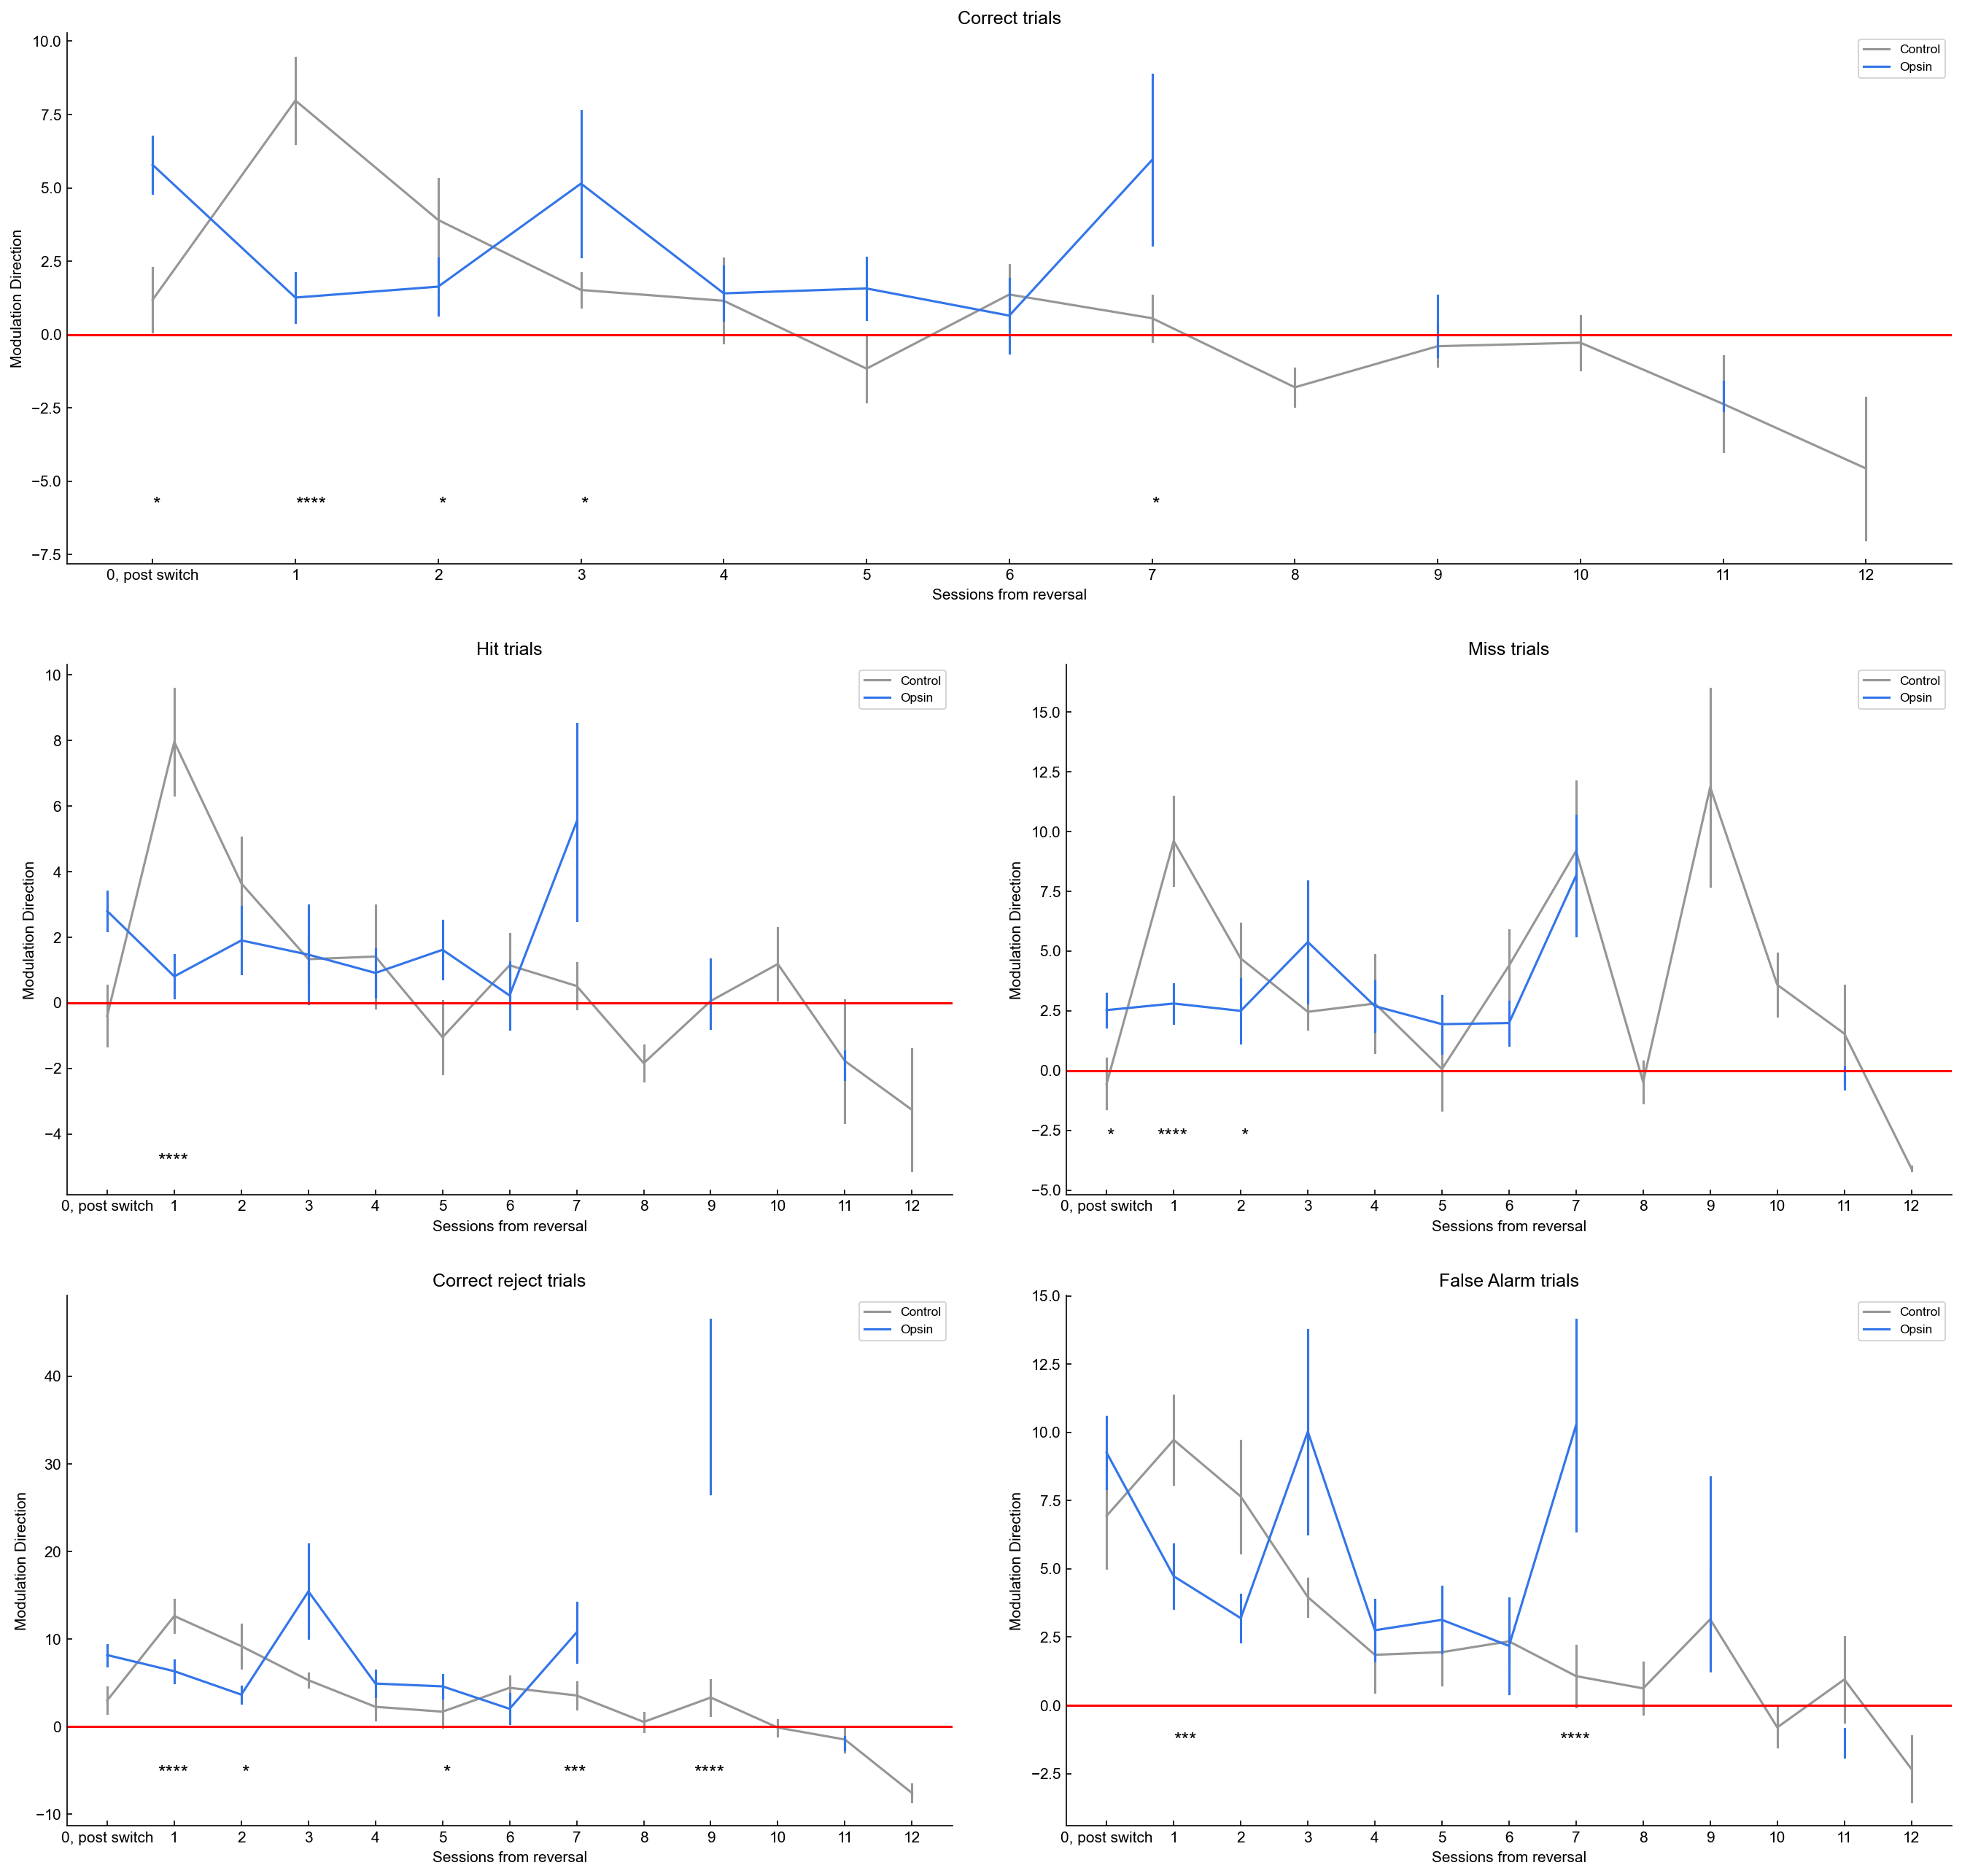

In [186]:
fig,ax = plt.subplots(6,1)
fig.set_figheight(18)
fig.set_figwidth(28)

ax[0] = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
ax[1] = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1)
ax[2] = plt.subplot2grid(shape=(3, 3), loc=(1, 1), rowspan=1)
ax[3] = plt.subplot2grid((3, 3), (2, 0))
ax[4] = plt.subplot2grid((3, 3), (2, 1), colspan=1)
fig.tight_layout(pad=5)

control_days = np.arange(0,13)#-0.03
opsin_days = np.arange(0,13)#+0.03

## CORRECT TRIALS
## sig testing and plotting
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    
    # skipping tests for days with no data
    if opsin_day_clust_on_corr_eors_noNan[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
    
    test = mannwhitneyu(dual_day_clust_off_corr_eors_noNan[i], opsin_day_clust_on_corr_eors_noNan[i]) 
   # test = mannwhitneyu(dual_day_clust_off_corr_eors_noNan[i],opsin_day_clust_on_corr_eors_noNan[i])
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = -6
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[0].text(i,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[0].text(i-.1,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[0].text(i-.2,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[0].text(i,sigYs, str('****'), size = 13)
##

ax[0].plot(control_days, dual_mean[0,:], color = GOOD_GREY, label = 'Control')
ax[0].plot(opsin_days, opsin_mean[0,:], color = LASER_COLOR, label = 'Opsin')
ax[0].plot([control_days, control_days], [dual_sem[0,:], dual_sem[1,:]], color = GOOD_GREY)
ax[0].plot([opsin_days, opsin_days], [opsin_sem[0,:], opsin_sem[1,:]], color = LASER_COLOR)

ax[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[0].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)

ax[0].set_xlabel('Sessions from reversal')
ax[0].set_ylabel('Modulation Direction')
ax[0].set_title('Correct trials')
ax[0].axhline(y=0, color='r', linestyle='-')
#ax[0].set_yscale('log')
ax[0].legend()

## HIT TRIALS
## sig testing and plotting
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    
    # skipping tests for days with no data
    if opsin_day_clust_on_hit_eors_noNan[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
    
    test = mannwhitneyu(dual_day_clust_off_hit_eors_noNan[i], opsin_day_clust_on_hit_eors_noNan[i]) 
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = -5
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[1].text(i,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[1].text(i-.1,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[1].text(i-.2,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[1].text(i-.25,sigYs, str('****'), size = 13)
##

ax[1].plot(control_days, dual_mean[1,:], color = GOOD_GREY, label = 'Control')
ax[1].plot(opsin_days, opsin_mean[1,:], color = LASER_COLOR, label = 'Opsin')
ax[1].plot([control_days, control_days], [dual_sem[2,:], dual_sem[3,:]], color = GOOD_GREY)
ax[1].plot([opsin_days, opsin_days], [opsin_sem[2,:], opsin_sem[3,:]], color = LASER_COLOR)

ax[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[1].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)

ax[1].set_xlabel('Sessions from reversal')
ax[1].set_ylabel('Modulation Direction')
ax[1].set_title('Hit trials')
ax[1].axhline(y=0, color='r', linestyle='-')
#ax[1].set_yscale('log')
ax[1].legend()

## MISS TRIALS
## sig testing and plotting
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    
    # skipping tests for days with no data
    if opsin_day_clust_on_miss_eors_noNan[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
    
    test = mannwhitneyu(dual_day_clust_off_miss_eors_noNan[i], opsin_day_clust_on_miss_eors_noNan[i]) 
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = -3
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[2].text(i,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[2].text(i-.1,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[2].text(i-.2,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[2].text(i-.25,sigYs, str('****'), size = 13)
##

ax[2].plot(control_days, dual_mean[2,:], color = GOOD_GREY, label = 'Control')
ax[2].plot(opsin_days, opsin_mean[2,:], color = LASER_COLOR, label = 'Opsin')
ax[2].plot([control_days, control_days], [dual_sem[4,:], dual_sem[5,:]], color = GOOD_GREY)
ax[2].plot([opsin_days, opsin_days], [opsin_sem[4,:], opsin_sem[5,:]], color = LASER_COLOR)

ax[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[2].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)

ax[2].set_xlabel('Sessions from reversal')
ax[2].set_ylabel('Modulation Direction')
ax[2].set_title('Miss trials')
ax[2].axhline(y=0, color='r', linestyle='-')
#ax[2].set_yscale('log')
ax[2].legend()

## CREJECT TRIALS
## sig testing and plotting
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    
    # skipping tests for days with no data
    if opsin_day_clust_on_creject_eors_noNan[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
    
    test = mannwhitneyu(dual_day_clust_off_creject_eors_noNan[i], opsin_day_clust_on_creject_eors_noNan[i]) 
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = -6
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[3].text(i,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[3].text(i-.1,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[3].text(i-0.2,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[3].text(i-0.25,sigYs, str('****'), size = 13)
##

ax[3].plot(control_days, dual_mean[3,:], color = GOOD_GREY, label = 'Control')
ax[3].plot(opsin_days, opsin_mean[3,:], color = LASER_COLOR, label = 'Opsin')
ax[3].plot([control_days, control_days], [dual_sem[6,:], dual_sem[7,:]], color = GOOD_GREY)
ax[3].plot([opsin_days, opsin_days], [opsin_sem[6,:], opsin_sem[7,:]], color = LASER_COLOR)

ax[3].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[3].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)

ax[3].set_xlabel('Sessions from reversal')
ax[3].set_ylabel('Modulation Direction')
ax[3].set_title('Correct reject trials')
ax[3].axhline(y=0, color='r', linestyle='-')
#ax[3].set_yscale('log')
ax[3].legend()

## FALARM TRIALS
## sig testing and plotting
sig = [0 for element in range(12)]
pval =[0 for element in range(12)]
for i in range(12):
    
    # skipping tests for days with no data
    if opsin_day_clust_on_falarm_eors_noNan[i] == []:
        
        pval[i] = 1
        sig[i] = np.abs(pval[i]) < 0.05
        
        continue
    
    test = mannwhitneyu(dual_day_clust_off_falarm_eors_noNan[i], opsin_day_clust_on_falarm_eors_noNan[i]) 
    pval[i] = test.pvalue
    sig[i] = np.abs(pval[i]) < 0.05
    
# plotting significance values
sig_where = np.where(sig) 
sigDays = np.array([items for items in sig_where[0]])
sigYs = -1.5
for i in range(12):
    if 0.01 < pval[i] < 0.05:
        ax[4].text(i,sigYs, str('*'), size = 13)
    if 0.005 < pval[i] < 0.01:
        ax[4].text(i,sigYs, str('**'), size = 13)
    if 0.001 < pval[i] < 0.005:
        ax[4].text(i,sigYs, str('***'), size = 13)
    if pval[i] < 0.001:
        ax[4].text(i-0.25,sigYs, str('****'), size = 13)
##
ax[4].plot(control_days, dual_mean[4,:], color = GOOD_GREY, label = 'Control')
ax[4].plot(opsin_days, opsin_mean[4,:], color = LASER_COLOR, label = 'Opsin')
ax[4].plot([control_days, control_days], [dual_sem[8,:], dual_sem[9,:]], color = GOOD_GREY)
ax[4].plot([opsin_days, opsin_days], [opsin_sem[8,:], opsin_sem[9,:]], color = LASER_COLOR)

ax[4].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[4].set_xticklabels(['switch day', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontsize = 10)

ax[4].set_xlabel('Sessions from reversal')
ax[4].set_ylabel('Modulation Direction')
ax[4].set_title('False Alarm trials')
ax[4].axhline(y=0, color='r', linestyle='-')
#ax[4].set_yscale('log')
ax[4].legend()

plt.savefig('Opsin effects on FR enhancement_suppresion, opsin vs control.pdf')